<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/official_langchain_neo4jvector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain openai wikipedia tiktoken neo4j langchain_openai

In [2]:
import os

from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain.document_loaders import WikipediaLoader
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

os.environ['OPENAI_API_KEY'] = "sk-"

# LangChain library adds full support for Neo4j Vector Index
## Streamlining data ingestion and querying in Retrieval-Augmented Generation Applications

If you have been on vacation for the past six months, first of all, congratulations. Secondly, you should know that since the introduction of ChatGPT-like large language models (LLM), the technology ecosystem has changed dramatically. Nowadays, it's all about retrieval-augmented generation (RAG) applications. The idea behind RAG applications is to provide additional context at query time to have the LLM generate accurate and up-to-date answers.

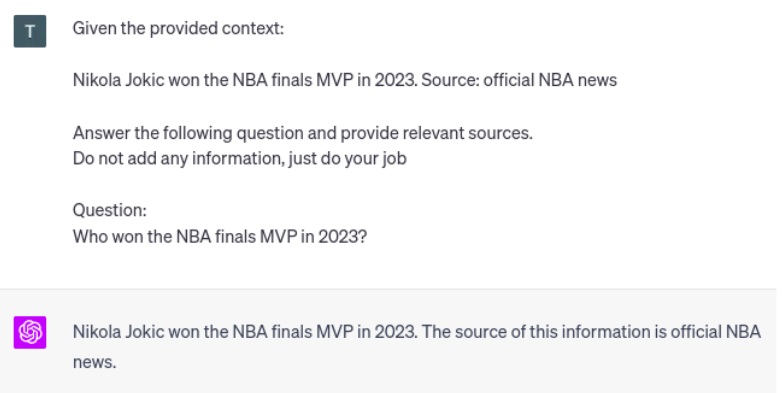

Neo4j has been and is excellent at storing and analyzing structured information in RAG applications. Furthermore, Neo4j added the vector index search only a couple of days ago, which brings it closer to supporting RAG applications based on unstructured text.

To streamline the use of Neo4j's vector index, I have integrated it into the LangChain library properly. LangChain is a leading framework for building LLM applications, integrating most LLM providers, databases, and more. It supports data ingestion as well as reading workflows and is especially useful for developing question-answering chatbots using the RAG architecture.

In this blog post, I'll guide you through an end-to-end example that demonstrates how to leverage LangChain for efficient data ingestion into Neo4j vector index, followed by the construction of a straightforward yet effective RAG application.

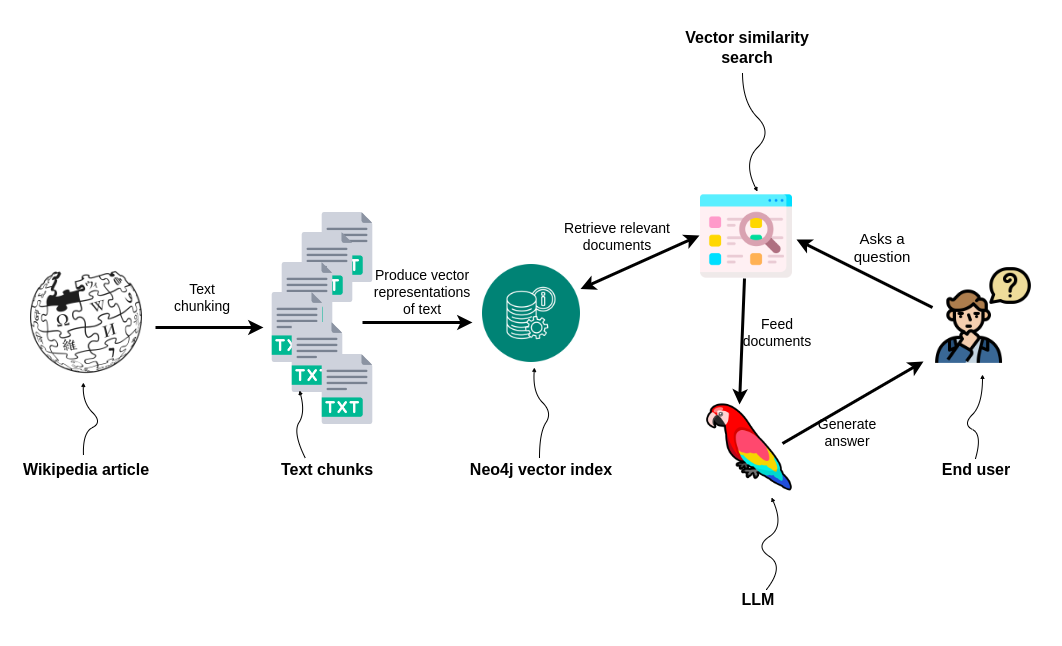

The tutorial will consist of the following steps:
* Read a Wikipedia article using a LangChain Document Reader
* Chunk the text
* Store the text into Neo4j and index it using the newly added vector index
* Implement a question-answering workflow to support RAG applications.

## Neo4j Environment setup
You need to setup a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on [Neo4j Aura](https://neo4j.com/cloud/platform/aura-graph-database/), which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.
## Reading and chunking a Wikipedia article
We will begin by reading and chunking a Wikipedia article. The process is pretty simple, as LangChain has integrated the Wikipedia document loader as well as the text chunking modules.

In [3]:
# Read the wikipedia article
raw_documents = WikipediaLoader(query="Leonhard Euler").load()
# Define chunking strategy
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=20
)
# Chunk the document
documents = text_splitter.split_documents(raw_documents)

Created a chunk of size 1130, which is longer than the specified 1000
Created a chunk of size 1221, which is longer than the specified 1000
Created a chunk of size 2331, which is longer than the specified 1000
Created a chunk of size 1623, which is longer than the specified 1000
Created a chunk of size 1572, which is longer than the specified 1000


In [4]:
# Remove summary from metadata
for d in documents:
    del d.metadata['summary']

Since Neo4j is a graph database, I thought using the Wikipedia article about Leonhard Euler as the example was only fitting. Next, we use the tiktoken text chunking module, which uses a tokenizer made by OpenAI, to split the article into chunks with 1000 tokens.

LangChain's WikipediaLoaderadds a summary to each chunk by default. I thought the added summaries were a bit redundant. For example, if you used a vector similarity search to retrieve the top three results, the summary would be repeated three times. Therefore, I decided to remove it from the dataset.

## Store and index the text with Neo4j
LangChain makes it easy to import the documents into Neo4j and index them using the newly added vector index. We tried to make it very user-friendly, which means that you don't have to know anything about Neo4j or graphs to use it. On the other hand, we provided several customization options for more experienced users, which will be presented in a separate blog post.

Neo4j vector index is wrapped as a LangChain vector store and, therefore, follows the syntax used to interact with other vector databases.

In [5]:
# Neo4j Aura credentials
url="bolt://54.236.226.158:7687"
username="neo4j"
password="radiuses-investment-college"

# Instantiate Neo4j vector from documents
neo4j_vector = Neo4jVector.from_documents(
    documents,
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password
)

The from_documents method connects to a Neo4j database, imports and embeds the documents, and creates a vector index. The data will be represented as the `Chunk` nodes by default. As mentioned, you can customize how the data should be stored, as well as which data should be returned. However, that will be discussed in the following blog post.

If you already have an existing vector index with populated data, you can use the from_existing_index method.
## Vector similarity search
We will begin with a simple vector similarity search to verify that everything works as intended.

In [6]:
query = "Where did Euler grow up?"

results = neo4j_vector.similarity_search(query, k=1)
print(results[0].page_content)

== Early life ==
Leonhard Euler was born on 15 April 1707, in Basel to Paul III Euler, a pastor of the Reformed Church, and Marguerite (née Brucker), whose ancestors include a number of well-known scholars in the classics. He was the oldest of four children, having two younger sisters, An


The LangChain module used the specified embedding function (OpenAI in this example) to embed the question and then find the most similar documents by comparing the cosine similarity between the user question and indexed documents.

Neo4j Vector index also supports the Euclidean similarity metric along with the cosine similarity.

## Question-answer workflow with LangChain

The nice thing about LangChain is that it supports question-answering workflows using only a line or two of code. For example, if we wanted to create a question-answering that generates answers based on the provided context but also provides which documents it used as the context, we can use the following code.

In [7]:
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

chain = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0),
    chain_type="stuff",
    retriever=neo4j_vector.as_retriever()
)

In [8]:
query = "What is Euler credited for popularizing?"

chain.invoke(
    {"question": query},
    return_only_outputs=True,
)

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


{'answer': "Euler is credited for popularizing modern notation and terminology in mathematics. He introduced the notation for functions, trigonometric functions, the base of the natural logarithm (Euler's number), and the use of the Greek letter π to represent the ratio of a circle's circumference to its diameter. He also invented the notation i to represent the imaginary unit. Additionally, Euler made important contributions to complex analysis and discovered Euler's formula, which is considered one of the most remarkable formulas in mathematics. He is also known for his work in calculus, graph theory, and number theory.",
 'sources': ''}

As you can see, the LLM constructed an accurate answer based on the provided Wikipedia article but also returned which source documents it used. And we only required one line of code to achieve this, which is pretty awesome if you ask me.

While testing the code, I noticed that the sources were not always returned. The problem here is not Neo4j Vector implementation but rather GPT-3.5-turbo. Sometimes, it doesn't listen to instructions to return the source documents. However, if you use GPT-4, the problem goes away.

Lastly, to replicate the ChatGPT interface, you can add a memory module, which additionally provides the LLM with dialogue history so that we can ask follow-up questions. Again, we only need two lines of codes.

In [9]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
qa = ConversationalRetrievalChain.from_llm(
    ChatOpenAI(temperature=0), neo4j_vector.as_retriever(), memory=memory)

Let's now test it out.

In [10]:
print(qa.invoke({"question": "What is Euler credited for popularizing?"})["answer"])

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Euler is credited for popularizing several mathematical concepts and notations. Some of the things he is credited for popularizing include:

1. The use of the Greek letter π (pi) to represent the ratio of a circle's circumference to its diameter.
2. The notation f(x) to represent a function.
3. The use of the letter i to represent the imaginary unit (√-1).
4. The modern notation for trigonometric functions.
5. The use of the letter e to represent the base of the natural logarithm (Euler's number).
6. The use of lowercase letters to represent the sides of a triangle and capital letters to represent the angles.
7. The use of the Greek letter Σ (sigma) to represent summations.
8. The use of the Greek letter Δ (delta) to represent finite differences.

These are just a few examples of the many mathematical concepts and notations that Euler is credited for popularizing.


And now a follow-up question.

In [11]:
print(qa.invoke({"question": "Where did he grow up?"})["answer"])

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  war

Euler grew up in Basel, Switzerland.


# Summary
The vector index is a great addition to Neo4j, making it an excellent solution for handling structured and unstructured data for RAG applications. Hopefully, the LangChain integration will streamline the process of integrating the vector index into your existing or new RAG applications, so you don't have to worry about the details. Remember, LangChain already [supports generating Cypher statements](https://towardsdatascience.com/langchain-has-added-cypher-search-cb9d821120d5) and using them to retrieve context, so you can use it today to retrieve both structured and unstructured information. We have many ideas on upgrading the LangChain support for Neo4j, so stay tuned!